# **ASL Alphabet Recognition**

### **(AIG 210 - Computer Vision - Group 4)**

## Load and Process the Data

In [5]:
import cv2
import os
import numpy as np
import mediapipe as mp
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=True, max_num_hands=1)

def extract_hand_landmarks(image):
    """Extract hand landmarks using MediaPipe and return a feature vector."""
    results = hands.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            landmark_list = []
            for landmark in hand_landmarks.landmark:
                landmark_list.extend([landmark.x, landmark.y, landmark.z])
            return landmark_list
    return np.zeros(21 * 3)  # If no hand detected, return a zero vector

def load_train_data(data_dir):
    images = []
    landmarks = []
    labels = []
    class_names = sorted(os.listdir(data_dir))
    for idx, class_name in enumerate(class_names):
        class_folder = os.path.join(data_dir, class_name)
        image_names = os.listdir(class_folder)
        for image_name in tqdm(image_names, desc=f'Loading {class_name}', leave=False):
            image_path = os.path.join(class_folder, image_name)
            image = cv2.imread(image_path)
            if image is not None:
                image = cv2.resize(image, (128, 128))
                landmark_features = extract_hand_landmarks(image)
                if landmark_features is not None:
                    images.append(image)
                    landmarks.append(landmark_features)
                    labels.append(idx)
    images = np.array(images) / 255.0  # Normalize images
    landmarks = np.array(landmarks)
    labels = to_categorical(labels, num_classes=len(class_names))
    return images, landmarks, labels, class_names

def load_test_data(data_dir, class_names):
    images = []
    landmarks = []
    labels = []
    image_names = os.listdir(data_dir)
    for image_name in tqdm(image_names, desc='Loading Test Data', leave=False):
        image_path = os.path.join(data_dir, image_name)
        image = cv2.imread(image_path)
        if image is not None:
            image = cv2.resize(image, (128, 128))
            landmark_features = extract_hand_landmarks(image)
            if landmark_features is not None:
                images.append(image)
                landmarks.append(landmark_features)
                # Extract class name from the file name
                class_label = image_name.split('_')[0]
                if class_label in class_names:
                    labels.append(class_names.index(class_label))
    images = np.array(images) / 255.0  # Normalize images
    landmarks = np.array(landmarks)
    labels = to_categorical(labels, num_classes=len(class_names))
    return images, landmarks, labels

train_dir = '/content/CV-Project/asl_alphabet_train'
test_dir = '/content/CV-Project/asl_alphabet_test'

X_train, landmarks_train, y_train, class_names = load_train_data(train_dir)

X_test, landmarks_test, y_test = load_test_data(test_dir, class_names)

## Data Splitting

In [6]:
# Split training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

print(f"Class names: {class_names}")
print(f"Training set: {X_train.shape[0]} images with {len(class_names)} classes")
print(f"Validation set: {X_val.shape[0]} images with {len(class_names)} classes")
print(f"Test set: {X_test.shape[0]} images")

Class names: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']
Training set: 78300 images with 29 classes
Validation set: 8700 images with 29 classes
Test set: 28 images


## Data Augmentation

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

datagen.fit(X_train)

## Build a CNN Model

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

def create_model(input_shape):
    model = Sequential([
        Input(shape=input_shape),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(len(class_names), activation='softmax')
    ])
    return model

input_shape = X_train.shape[1:]  # (128, 128, 3)
model = create_model(input_shape)
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 29)                  │           3,741 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,308,381 (12.62 MB)

 Trainable params: 3,308,381 (12.62 MB)

 Non-trainable params: 0 (0.00 B)

## Train the Model

In [9]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Save the best model
checkpoint = ModelCheckpoint('asl_model_cnn.keras', monitor='val_loss', save_best_only=True)

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=20,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, checkpoint],
    verbose=1
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2447/2447 ━━━━━━━━━━━━━━━━━━━━ 284s 113ms/step - accuracy: 0.2346 - loss: 2.5677 - val_accuracy: 0.8093 - val_loss: 0.6299
Epoch 2/20
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 271s 111ms/step - accuracy: 0.6602 - loss: 0.9712 - val_accuracy: 0.9201 - val_loss: 0.2708
Epoch 3/20
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 271s 111ms/step - accuracy: 0.7685 - loss: 0.6504 - val_accuracy: 0.9407 - val_loss: 0.1888
Epoch 4/20
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 270s 110ms/step - accuracy: 0.8157 - loss: 0.5119 - val_accuracy: 0.9657 - val_loss: 0.1126
Epoch 5/20
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 269s 110ms/step - accuracy: 0.8489 - loss: 0.4227 - val_accuracy: 0.9697 - val_loss: 0.1014
Epoch 6/20
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 269s 110ms/step - accuracy: 0.8711 - loss: 0.3612 - val_accuracy: 0.9851 - val_loss: 0.0588
Epoch 7/20
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 269s 110ms/step - accuracy: 0.8884 - loss: 0.3172 - val_accuracy: 0.9877 - val_loss: 0.0442
Epoch 8/20
2447/2447 ━━━━━━━━━━━━━━━━━━━━ 270s 110ms/step - accuracy: 0.9

## Evaluate the Model

In [17]:
from tensorflow.keras.models import load_model

test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test loss: {test_loss}, Test accuracy: {test_accuracy}")

model = load_model('asl_model_cnn.keras')

model.save('asl_model_cnn.h5')

Test loss: 0.00015977173461578786, Test accuracy: 1.0


## Generate Confusion Matrix and Classification Report

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


<Figure size 1200x800 with 0 Axes>

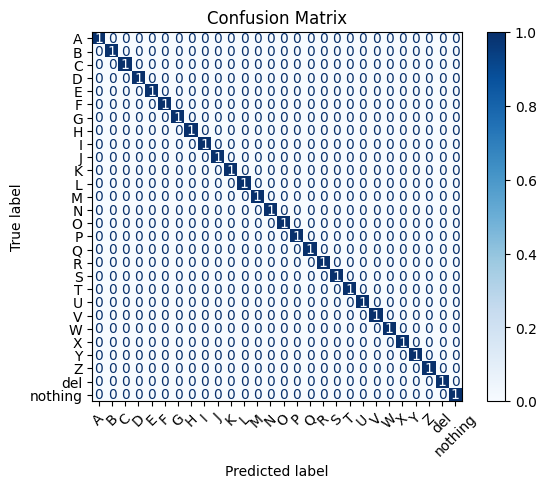

Classification Report:
               precision    recall  f1-score   support

           A       1.00      1.00      1.00         1
           B       1.00      1.00      1.00         1
           C       1.00      1.00      1.00         1
           D       1.00      1.00      1.00         1
           E       1.00      1.00      1.00         1
           F       1.00      1.00      1.00         1
           G       1.00      1.00      1.00         1
           H       1.00      1.00      1.00         1
           I       1.00      1.00      1.00         1
           J       1.00      1.00      1.00         1
           K       1.00      1.00      1.00         1
           L       1.00      1.00      1.00         1
           M       1.00      1.00      1.00         1
           N       1.00      1.00      1.00         1
           O       1.00      1.00      1.00         1
           P       1.00      1.00      1.00         1
           Q       1.00      1.00      1.00         1
   

In [14]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true, y_pred)

# Display the confusion matrix
plt.figure(figsize=(12, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names[:len(cm)])
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45)
plt.title("Confusion Matrix")
plt.show()

# Generate classification report
report = classification_report(y_true, y_pred, target_names=class_names[:len(cm)])
print("Classification Report:\n", report)

## Visualize Training History

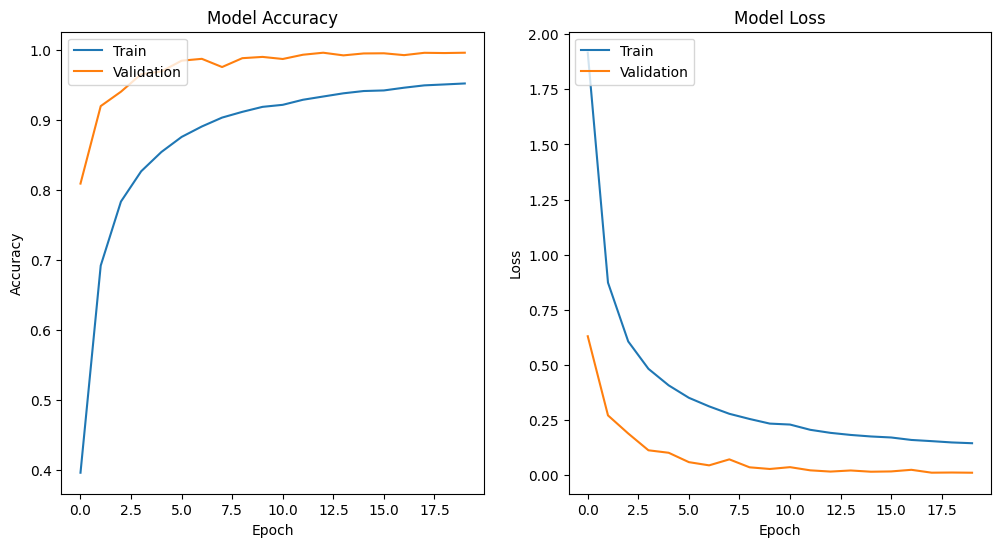

In [15]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

## Save Dataset Splits to CSV

In [20]:
import pandas as pd

def create_csv(data_dir, csv_filename):
    class_names = sorted(os.listdir(data_dir))
    data_entries = []
    for idx, class_name in enumerate(class_names):
        class_folder = os.path.join(data_dir, class_name)
        for image_name in os.listdir(class_folder):
            image_path = os.path.join(class_folder, image_name)
            data_entries.append((image_path, class_name))
    df = pd.DataFrame(data_entries, columns=['Image Path', 'Class Name'])
    df.to_csv(csv_filename, index=False)

def create_csv_from_filenames(data_dir, csv_filename):
    data_entries = []
    for image_name in os.listdir(data_dir):
        image_path = os.path.join(data_dir, image_name)
        class_name = image_name.split('_')[0]
        data_entries.append((image_path, class_name))
    df = pd.DataFrame(data_entries, columns=['Image Path', 'Class Name'])
    df.to_csv(csv_filename, index=False)

train_dir = '/content/CV-Project/asl_alphabet_train'
test_dir = '/content/CV-Project/asl_alphabet_test'

create_csv(train_dir, 'train_data.csv')
create_csv_from_filenames(test_dir, 'test_data.csv')